In [1]:
# %pip install openpyxl             # Для pd.read_excel
# %pip install pymorphy2
# %pip install pymorphy3

In [2]:
import re
import random
import numpy as np
import itertools

import pandas as pd
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

In [3]:
import pymorphy3        # Модуль для анализа слов в предложении

In [4]:
df = pd.read_excel('./mails.xlsx')

print(f"{df['class'].unique() = }")         # Какие классы используюутся ([1, 2, 3, 4, 6, 5, 7, 8])
print(f"{df['TYPE_HOTLINE'].unique() = }")  # Какие TYPE_HOTLINE используюутся ([1, 2, 3])


df['class'].unique() = array([1, 6, 5, 2, 3, 4, 8, 7], dtype=int64)
df['TYPE_HOTLINE'].unique() = array([2, 1, 3], dtype=int64)


In [5]:
df.head(2)

,CONTENT,TYPE_HOTLINE,class
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6


In [6]:
# Меняем наименование столбца только для удобства
df.rename(columns={'CLASS_': 'lbl'}, inplace=True)
# Для удобства добавляем два столбца с наименованиями классов и каналов поствупления обращений.
cls_dic = {1:['Условия подачи','Условия подачи документов, сроки, документы, места, льготы'],
           2:['Проходной и допустимый балл','Минимальный проходной балл и Минимальный балл для подачи заявления'],
           3:['Достижения','Индивидуальные достижения.'],
           4:['Общежития','Общежития'],
           5:['Вступительные испытания','Вступительные испытания, экзамены, кто может поступать и сдавать экзамены'],
           6:['Перевод','Перевод с направления на направление'],
           7:['Аспирантура','Вопросы по аспирантуре'],
           8:['Регистрация','Регистрация в электронных системах'],
           }
hlt_dic = {1:'ONLINE приёмная',
           2:'Очная приемная',
           3:'Приёмная аспирантуры'
           }

df['cls_name'] = df['class'].map(lambda x: cls_dic[x][0])
df['hlt_name'] = df.TYPE_HOTLINE.map(lambda x: hlt_dic[x])
df.head(10)

,CONTENT,TYPE_HOTLINE,class,cls_name,hlt_name
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1,Условия подачи,Очная приемная
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6,Перевод,Очная приемная
2,Здравствуйте! Скажите пожалуйста могу ли я под...,2,1,Условия подачи,Очная приемная
3,Здравствуйте! Где взять и куда подать заявлени...,2,1,Условия подачи,Очная приемная
4,Здравствуйте! Есть два высших образования (пла...,2,1,Условия подачи,Очная приемная
5,"Здравствуйте,возможен ли перевод в ваш вуз на ...",1,6,Перевод,ONLINE приёмная
6,Здравствуйте! Можно ещё подать заявку на пос...,2,1,Условия подачи,Очная приемная
7,Здравствуйте!\n\nне хватило # балла по биологи...,1,5,Вступительные испытания,ONLINE приёмная
8,Здравствуйте! Не нашли информацию. Какие резул...,2,5,Вступительные испытания,Очная приемная
9,Здравствуйте!мое первое высшее образование пла...,2,1,Условия подачи,Очная приемная


Классы сообщений:

In [7]:
cls_list = []
for i in range(1, len(cls_dic)+1):
  cls_list.append(cls_dic[i][0])
cls_list

['Условия подачи',
 'Проходной и допустимый балл',
 'Достижения',
 'Общежития',
 'Вступительные испытания',
 'Перевод',
 'Аспирантура',
 'Регистрация']

In [8]:
df.shape   # (588, 5) -> 588 строк и 5 столбцов

(588, 5)

### Анализ, визуализация и сбалансированность датасета

In [9]:
g = df.groupby('cls_name')['cls_name'].count().sort_values()
print(g)

cls_name
Аспирантура                      5
Регистрация                     16
Проходной и допустимый балл     24
Общежития                       28
Достижения                      29
Перевод                         42
Вступительные испытания        155
Условия подачи                 289
Name: cls_name, dtype: int64


In [10]:
g = df.groupby('TYPE_HOTLINE')['TYPE_HOTLINE'].count().sort_values()
print(g)

TYPE_HOTLINE
3      6
1     45
2    537
Name: TYPE_HOTLINE, dtype: int64


# Задача 1. Подготовка данных
Предобработка текста писем: удаление из текста лишней информации, которая не нужна для получения основной мысли сообщения и классификации его.

#### Приведение слов в нормальную форму

In [11]:
def morphan(word, morph):
    '''
    Приведение слов в нормальную форму, удаление числительных и ФИО.
    '''
    word = word.strip()         # Удаляет пробелы до и после слова
    p = morph.parse(word)[0]    # Разбираем (анализируем) слово с pymorphy3

    word_new = word
    if (not 'Surn' in p.tag) and (not 'Name' in p.tag) and (not 'Patr' in p.tag) and ('NOUN' in p.tag):
        # Cуществительное, но не ФИО (surname, name, patronymic)
        word_new = p.normal_form
    # Иначе все фамилии, имена и отчества заменяются на статичное "Фамилия", "Имя", "Отчество"
    elif 'Surn' in p.tag:
        word_new = 'ФАМИЛИЯ'
    elif 'Name' in p.tag:
        word_new = 'ИМЯ'
    elif 'Patr' in p.tag:
        word_new = 'ОТЧЕСТВО'

    # Глагол
    elif ('INFN' in p.tag) or ('VERB' in p.tag): 
        word_new = p.normal_form

    # Прилагательное
    elif ('ADJF' in p.tag) or ('ADJS' in p.tag) or ('COMP' in p.tag): 
        word_new = p.normal_form

    # Причастие, похоже на глагол
    elif ('PRTF' in p.tag) or ('PRTS' in p.tag) or ('GRND' in p.tag): 
        word_new = p.normal_form

    # Предлоги, местоимения и пр.
    elif ('ADVB' in p.tag) or ('NPRO' in p.tag) or ('PRED' in p.tag) or ('PREP' in p.tag) or ('CONJ' in p.tag) or ('PRCL' in p.tag) or ('INTJ' in p.tag):    
        word_new = p.normal_form

     # Числительные NUMB, межометия intg
    elif ('NUMR' in p.tag) or ('NUMB' in p.tag) or ('intg' in p.tag):
        word_new = ''

    else:
        word_new = word
    return word_new

In [12]:
def normtext(txt, morph):
    '''
    Возвращает текст из слов в нормальной форме
    '''
    txt = re.sub(r"[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+", ' ', txt)  # Заменяем знаки пунктуаци и спецсиволы на пробелы
    txt = txt.replace('\n','')
    return str(' '.join([morphan(x, morph) for x in txt.split()]))

**Улучшения**

In [13]:
# Удалене слов, которые меньше двух букв
def remove2(txt):
    return ' '.join([x if len(x) > 2 else '' for x in txt.split()])

In [14]:
# Удаление лишних слов
def re_gr(txt):
    stop_words = ['спасибо','подскажите','скажите','объясните','пожалуйста', 'здравствуйте',
    'добрый день', 'доброго дня', 'С уважением', 'они']
    for x in stop_words:
        txt = txt.replace(x,'')
    return txt

**Обработка текста**

In [15]:
def prepare_dataframe(df):
  df['text'] = df['CONTENT'].map(lambda x: x.lower()).map(re_gr)      # Удаление линих слов
  morph = pymorphy3.MorphAnalyzer()
  df['text'] = df.text.map(lambda x: normtext(x, morph))              # Текст в нормальной форме + удаление пунктуации
  df['text'] = df.text.map(remove2)                                   # Удаление слов, которые меньше 2-х символов
  return df
  

df = prepare_dataframe(df)
df.to_excel(r'df_prep.xlsx', index=False)       # Сохраняем обработанные данные

# ML - Классификация


#### Подбор параметра

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3, stratify=df['class'])

tfv = TfidfVectorizer()                 # Функция получения векторного представления
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)          

**Было**

In [17]:
# param_grid = {'C': [1.,10.0]}           # Регуляризационный параметр C для логистической регрессии

# grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)

# grid_search.fit(X_train, y_train)
# grid_search.score(X_test, y_test)
# grid_search.best_params_                # Лучшие параметры

**Стало**

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [19]:
# Определение параметров для различных моделей
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}


# Создание экземпляров моделей
rf = RandomForestClassifier()       # Случайный лес
gb = GradientBoostingClassifier()   # GradientBoosting    

# GridSearch для каждой модели
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=4)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=4)

# Обучение моделей
grid_search_rf.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]})

In [20]:
# Оценка каждой модели на тестовых данных
print("Random Forest Best Params:", grid_search_rf.best_params_)
print("Random Forest Test Score:", grid_search_rf.score(X_test, y_test))

print('===========================================================')

print("Gradient Boosting Best Params:", grid_search_gb.best_params_)
print("Gradient Boosting Test Score:", grid_search_gb.score(X_test, y_test))

Random Forest Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Test Score: 0.7853107344632768
Gradient Boosting Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Gradient Boosting Test Score: 0.7966101694915254


In [21]:
# Создание ансамбля с VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', grid_search_rf.best_estimator_),
    ('gb', grid_search_gb.best_estimator_),
], voting='soft')  

# Обучение ансамбля
ensemble_model.fit(X_train, y_train)

# Оценка ансамбля
ensemble_score = ensemble_model.score(X_test, y_test)
print("Ensemble Model Test Score:", ensemble_score)

Ensemble Model Test Score: 0.7966101694915254


{'C': 10.0}

In [22]:
def classifier(X_train, y_train, C=10.0):
    tfv = TfidfVectorizer()
    X_train = tfv.fit_transform(X_train)

    # Было
    # clf = LogisticRegression(C=C)
    # clf = clf.fit(X_train, y_train)
    
    # Стало
    clf = ensemble_model.fit(X_train, y_train)

    return tfv, clf

def predictor(text, clf, tfv):
    X_test = tfv.transform([text])
    pred = clf.predict(X_test)
    return pred[0]

In [23]:
# Обучение
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.1, stratify=df['class'])
tfv, clf = classifier(X_train, y_train, C=10.0)

In [24]:
# Предсказание
pred_save = []
class_save = []
pred = []
for nom, txt in enumerate(X_test.values):
    pred.append(predictor(txt, clf, tfv))


In [25]:
y_test_list = y_test.tolist()
y_test_list.extend(class_save)
pred_list = pred[:]
pred_list.extend(pred_save)

mtrs = classification_report([cls_dic[x][0] for x in y_test_list], [cls_dic[x][0] for x in pred_list])
print(mtrs)

                             precision    recall  f1-score   support

    Вступительные испытания       0.92      0.75      0.83        16
                 Достижения       1.00      0.33      0.50         3
                  Общежития       1.00      0.67      0.80         3
                    Перевод       0.75      0.75      0.75         4
Проходной и допустимый балл       1.00      0.50      0.67         2
                Регистрация       1.00      1.00      1.00         2
             Условия подачи       0.75      0.93      0.83        29

                   accuracy                           0.81        59
                  macro avg       0.92      0.70      0.77        59
               weighted avg       0.84      0.81      0.81        59



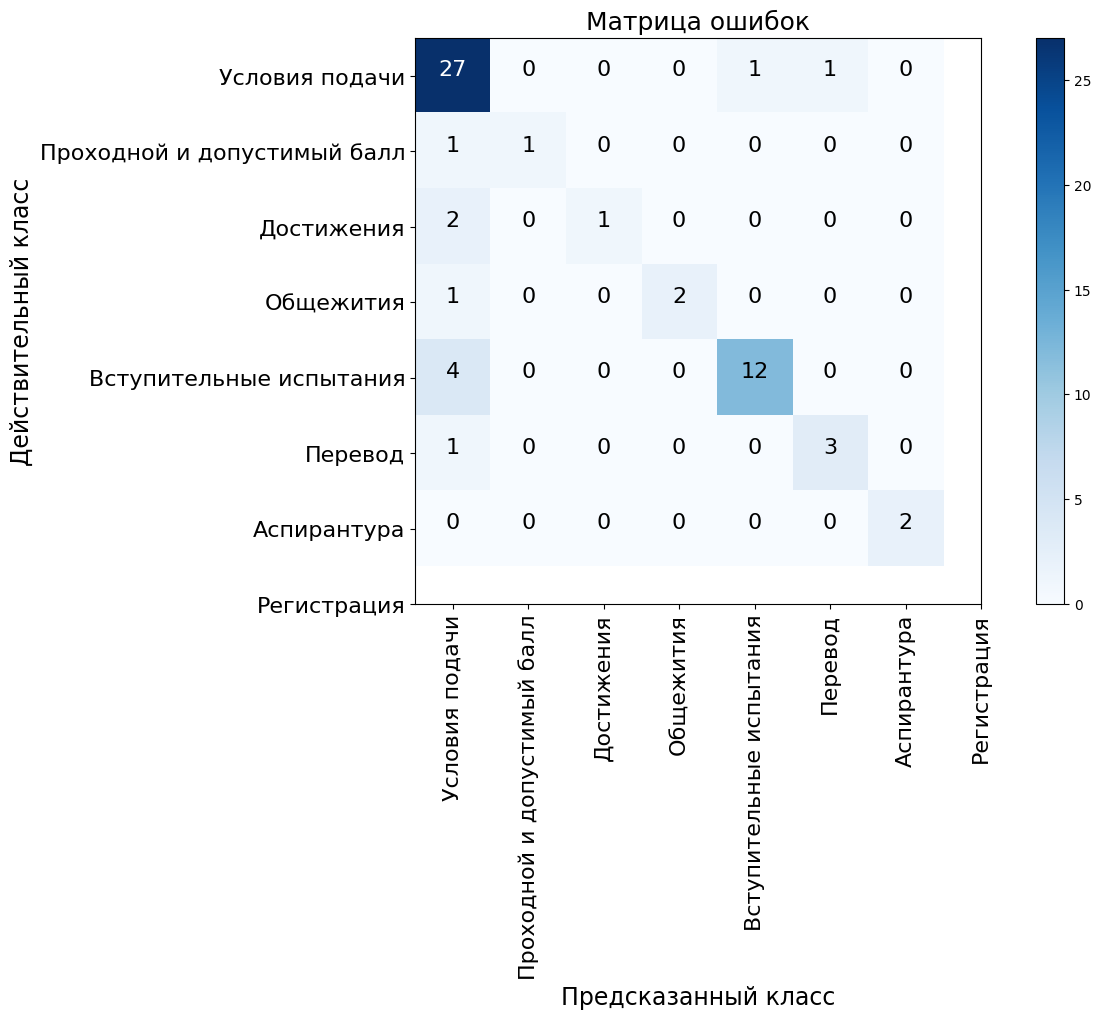

In [26]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.show()

conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y_test_list, pred_list)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

#  RNN - классификация

In [27]:
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM


# LSTM

In [28]:
# Создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(X_train)

In [29]:
X_train_1, X_vt_1, y_train_1, y_vt_1 = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_vt_1, y_vt_1, test_size=0.5, random_state=42)

In [30]:
# Максимальное количество слов в самом длинном письме
max_words = 0
for desc in df.text.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном письме: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = max_words

Максимальное количество слов в самом длинном письме: 78 слов
Всего уникальных слов в словаре: 1316


In [31]:
# Преобразуем описания заявок в векторы чисел
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.text)

X_train = tokenizer.texts_to_sequences(X_train_1)
X_valid = tokenizer.texts_to_sequences(X_valid_1)
X_test = tokenizer.texts_to_sequences(X_test_1)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_valid:', X_valid.shape)
print('Размерность X_test:', X_test.shape)

# Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)

num_classes = df['class'].unique().shape[0]+1

y_train = keras.utils.to_categorical(y_train_1, num_classes)
y_valid = keras.utils.to_categorical(y_valid_1, num_classes)
y_test = keras.utils.to_categorical(y_test_1, num_classes)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

Размерность X_train: (411, 78)
Размерность X_valid: (88, 78)
Размерность X_test: (89, 78)
y_train shape: (411, 9)
y_valid shape: (88, 9)
y_test shape: (89, 9)


**Было**

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from keras.optimizers import Adam, RMSprop, SGD
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy

**Было**

In [33]:
# # максимальное количество слов для анализа
# max_features = vocab_size

# print(u'Собираем модель...')
# model = Sequential()
# model.add(Embedding(max_features, maxSequenceLength))
# model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
# model.add(Dense(num_classes, activation='sigmoid'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# print (model.summary())

**Стало**

In [34]:
# максимальное количество слов для анализа
max_features = vocab_size
embedding_dim = 128       # Размерность слоя Embedding
dropout_rate = 0.01       # Значение dropout
gru_units = 128           # Количество нейронов в слое GRU


print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxSequenceLength))
model.add(GRU(units=gru_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
model.add(Dense(num_classes, activation='sigmoid'))                 # Для многоклассовой классификации

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...


c:\Users\murza\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3715 - loss: 2.0522 - val_accuracy: 0.5000 - val_loss: 1.4328
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5260 - loss: 1.3721 - val_accuracy: 0.5000 - val_loss: 1.3754
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4960 - loss: 1.3112 - val_accuracy: 0.5000 - val_loss: 1.3181
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4828 - loss: 1.2256 - val_accuracy: 0.5000 - val_loss: 1.2205
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5855 - loss: 1.0471 - val_accuracy: 0.5455 - val_loss: 1.1084
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7007 - loss: 0.9128 - val_accuracy: 0.6477 - val_loss: 0.9703
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7385 - loss: 0.7997 - val_accuracy: 0.6932 - val_loss: 0.9750
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7548 - loss: 0.6685 - val_

In [36]:
predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [37]:
print(classification_report(y2, pred2))

              precision    recall  f1-score   support

           1       0.78      0.80      0.79        45
           2       0.50      0.67      0.57         3
           3       0.67      0.50      0.57         4
           4       0.29      1.00      0.44         2
           5       0.86      0.72      0.78        25
           6       0.17      0.25      0.20         4
           7       0.00      0.00      0.00         1
           8       0.50      0.20      0.29         5

    accuracy                           0.70        89
   macro avg       0.47      0.52      0.46        89
weighted avg       0.73      0.70      0.70        89



c:\Users\murza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\murza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\murza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

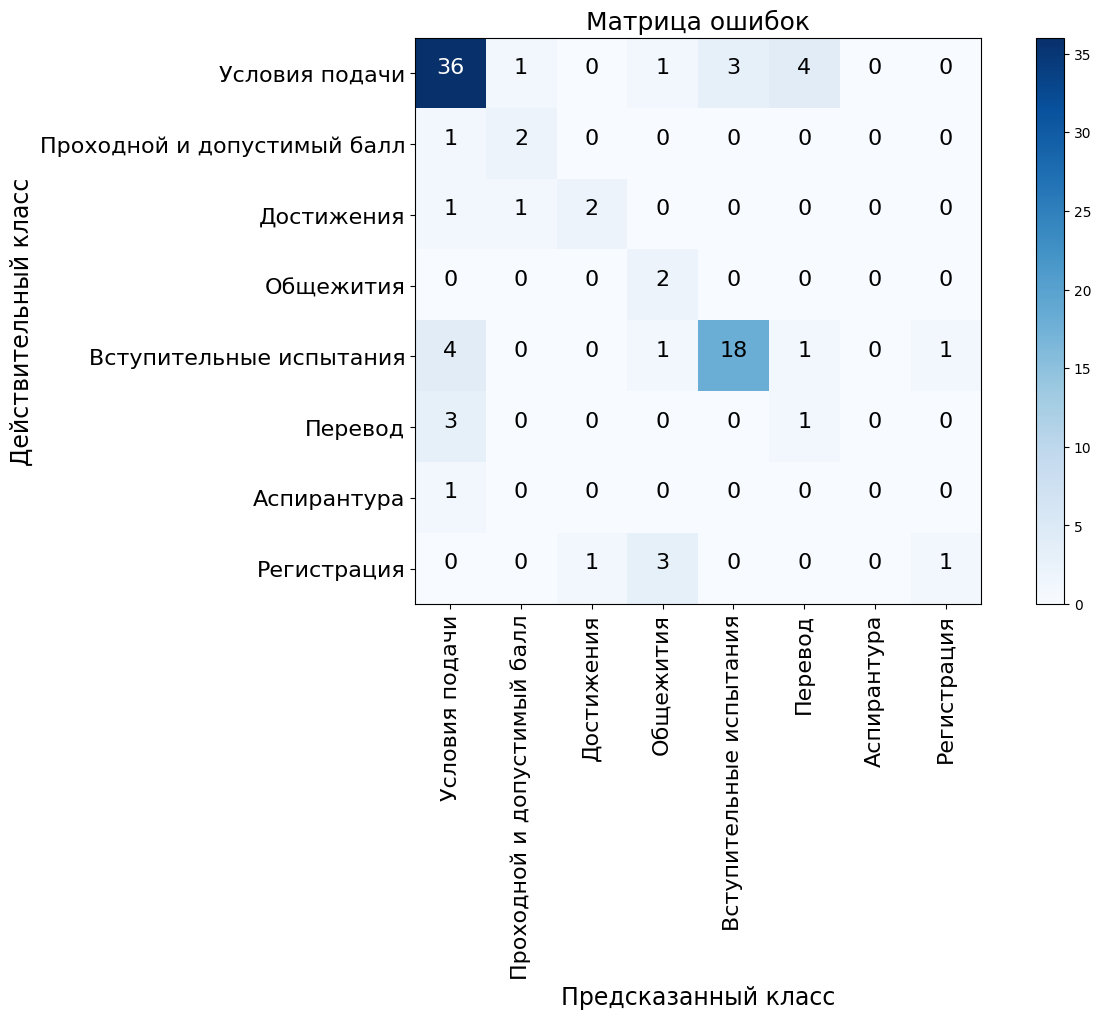

In [38]:
# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)